In [10]:
#Txt to Bin with Toeplitz

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from sortedcontainers import SortedDict
import scipy
from functools import reduce
from operator import add
import csv


# Defined Functions

## Data Manipualtion and Formatting

In [28]:
def Dict_sort(data, x_norm=False, y_norm=False):
    Map = SortedDict()
    avg = np.average(data)
    Max_val = 0 
    
    for val in data:
        # Add new item, normalized or not
        if x_norm == True:
             Key = val - avg
        else:
            Key = val
        # Look in the map, if new, make a new entry. otherwise, add one.
        if Map.__contains__(Key) == True:
            Old_val = Map.pop(Key)
            Map.__setitem__(Key,Old_val+1)
        else:
            Map.__setitem__(Key,1)
    if y_norm == True:
        for Key in Map:
            temp = Map.pop(Key)
            Map.__setitem__(Key,temp/len(data))
    return Map

def Data_loading(filename, formatted = False, bits = 2):
    uart_grey = []
    with open(filename) as fp:
        fp.seek(0)
        contents = fp.read()
        for entry in contents.split('\n'):
            try:
                uart_grey.append(int(entry))
            except:
                pass
    if formatted == True:
        uart_grey = reformatter(uart_grey, bits)
    return uart_grey

def reformatter(data, bits = 2):
    formatted_data = []
    if bits == 2:
        for i in range(0, int(len(data)/4),1):
            a = (data[i+0] & 0b110) << 5
            b = (data[i+1] & 0b110) << 3
            c = (data[i+2] & 0b110) << 1
            d = (data[i+3] & 0b110) >> 1 
            formatted_data.append(a|b|c|d)
    if bits == 4:
        for i in range(0, int(len(data)/2),1):
            a = (data[i+0] & 0b1111) << 4
            b = data[i+1] & 0b1111
            formatted_data.append((a|b))
    return formatted_data
        
def Data_sorting(data, X_norm = False, Y_norm = True):
    MyMap3 = SortedDict()
    MaxVal = 0
    avg = np.average(data)
    for a in range(len(data)):
        if X_norm == True:
            Key = data[a] - avg
        else:
            Key = data[a]
        if MyMap3.__contains__(Key) == True:
            OldVal = MyMap3.pop(Key)
            MyMap3.__setitem__(Key,OldVal+1)
            if OldVal+1 > MaxVal:
                MaxVal = OldVal+1
        else:
            MyMap3.__setitem__(Key,1)
    if Y_norm == True:
        for Key in MyMap3:
                OldVal = MyMap3.pop(Key)
                MyMap3.__setitem__(Key,OldVal/len(data))
    return MyMap3.keys(), MyMap3.values()

def Loading_CSV(filename, Headers = 0):
    q=0
    file = open(filename)
    csvreader = csv.reader(file)
    for i in range(Headers):
        header = next(csvreader)
    rows = []
    stats = []
    for row in csvreader:
            if q < 60:
                rows.append([float(i) for i in row])
            if q >= 60:
                stats.append(row)
            q=q+1
    #print(rows[0])
    file.close()
    return rows, stats

## Algorithms and Generators

In [12]:
def Min_entropy(data):
    Map = Dict_sort(data,x_norm = False, y_norm = True)
    entropy = - np.log2(max(Map.values()))
    return entropy

def Poisson_list(Center, Samples):
    s = []
    for i in range(0, Samples, 1):
        s.append(np.random.poisson(Center))
    return s

# Calulating the SOCF between two sets of data
def SOCF(data1, data2):
    
    # Calculating the sums
    sum12=0
    for i in range(0, len(data1), 1):
        sum12+= data1[i]*data2[i]
    
    #Calculating the averages
    avg12= sum12/len(data1)
    avg1= np.average(data1)
    avg2= np.average(data2)
    
    # Calculating the SOCF
    SOCF = avg12/(avg1*avg2)
    return SOCF

# Calculating the Autocorrelation function between to data sets 
def Inter_Auto_Corr(data1,data2):
    
    # Calculating the average
    data1_avg = np.average(data1)
    data2_avg = np.average(data2)

    # Calculating the variance and STD
    var1_temp = 0
    var2_temp = 0
    for val in range(0, len(data1), 1):
        var1_temp += (data1[val] - data1_avg)**2
        var2_temp += (data2[val] - data2_avg)**2
    data1_var = var1_temp/len(data1)
    data2_var = var2_temp/len(data2)
    data1_std = data1_var**(1/2)
    data2_std = data2_var**(1/2)

    # Calculating ACF
    acf_sum = 0
    for val in range(0, len(data1), 1):
        acf_sum += (data1[val] - data1_avg) * (data2[val] - data2_avg)
    acf = (acf_sum/len(data1))/(data1_std*data2_std)
    return acf

def calc_mutual_information(U, V):
    N = len(U)
    MI = 0
    for i in np.unique(U):
        for j in np.unique(V):
            # Calculate |U_i ∩ V_j|
            U_i = (U == i)
            V_j = (V == j)
            U_i_V_j = np.sum(np.logical_and(U_i, V_j))
            
            # Calculate |U_i|
            U_i = np.sum(U_i)
            
            # Calculate |V_j|
            V_j = np.sum(V_j)
            
            # Calculate mutual information
            if U_i_V_j > 0:
                MI += (U_i_V_j / N) * np.log(N * U_i_V_j / (U_i * V_j))
    return MI

def corr_stats(data):
    n = len(data)
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data) / n
    return mean, variance


## Plotting

In [45]:
def plot_w_error_band(Exposure ,mean, var, label = "LED" ,y_label = "", leg_loc = "upper right", figname = "evolution"):
     # Drawing the lines
    plt.plot(Exposure, mean)
    
    #plt.scatter(Exposure, mean, color = 'blue', zorder=0,label='Cree LED')
    
    Hmean = []
    Lmean = []
    for i in range(0, len(mean),1):
        Hmean.append(mean[i]+var[i])
        Lmean.append(mean[i]-var[i])
    
    plt.fill_between(Exposure, Hmean,Lmean, alpha = 0.15, label = label)

    # Setting the x and y axes' labels
    plt.xlabel("Exposure (\u03BCs)", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    # Setting the x Axis Limit
    #plt.xlim(-1, len(Exposure))

    # Setting the number of x ticks
    #plt.xticks(np.arange(0,len(Exposure),step=len(Exposure)/10))
    plt.legend(loc = leg_loc)
    plt.rcParams["figure.figsize"] = (6,6)
    plt.savefig(figname+".png" , bbox_inches='tight')

# Generating Plots

## Poisson Distribution

In [43]:
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
plt.figure(figsize=(10,4),dpi = 100)
for i in range(40,990,150):
    # Experimental Data
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    keys,values = Data_sorting(data, Y_norm = True)
    plt.bar(keys, values, label = str(i)+" \u03BCs")
    
    # Theortical
    x = np.arange(0, len(data))
    y = scipy.stats.poisson.pmf(x, np.average(data))
    x = x[0:300]
    y = [q * 1 for q in y[0:300]]
    plt.plot(x,y)
    print(i,"the average is",np.average(data),"variance is",np.var(data))


plt.xlabel("Pixel Counts", fontsize=12)
plt.ylabel("Count Probability", fontsize=12)
plt.legend(loc= 'upper right', fontsize=8)
plt.savefig("Poisson Evolution.png", bbox_inches = "tight")
plt.plot()

40 the average is 15.220277777777778 variance is 11.955088811728395
190 the average is 51.430277777777775 variance is 47.07902770061729
340 the average is 88.97666666666667 variance is 91.51334444444446
490 the average is 127.79666666666667 variance is 123.7231
640 the average is 158.92111111111112 variance is 154.7787765432099
790 the average is 198.22 variance is 208.2454888888889
940 the average is 237.51055555555556 variance is 247.43655524691357


[]

## Fano Factor Evolution

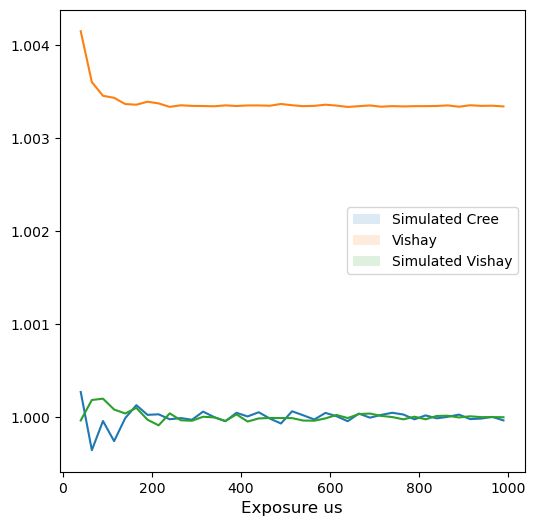

In [33]:
# CP41B LED
LED = "CP41B LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/CP41B/Spatial_SOCF_"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    mean.append(np.average(data))
    var.append(np.var(data))
    Exposure.append(i)
#plot_w_error_band(Exposure ,mean, var, label = "Cree")

# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    SOCF_array = []
    for q in range(0,100, 1):
        if q == 1830:
            SOCF_array.append(SOCF(Ref_pixel, Ref_pixel))
        else:
            SOCF_array.append(SOCF(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(SOCF_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Cree")

# TLHG LED
LED = "TLHG LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/TLHG/Spatial_SOCF_"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "Spatial_SOCF_correlations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Vishay")

# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/TLHG/ROI60x60/exp"
File_final = "gain20.000000Voltage1.910000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    SOCF_array = []
    for q in range(0,100, 1):
        if q == 1830:
            SOCF_array.append(SOCF(Ref_pixel, Ref_pixel))
        else:
            SOCF_array.append(SOCF(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(SOCF_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Vishay", leg_loc ="center right")

## Second Order Correlation Function

[8.385254568219434e-06, 5.9976315556326466e-06, 3.6516663310444536e-06, 2.2379303714024693e-06, 1.8899458349478395e-06, 1.232772318073763e-06, 1.0607260866589544e-06, 8.45165622220991e-07, 5.730753984876547e-07, 5.260597011111126e-07, 4.196906711111107e-07, 4.138662188194428e-07, 3.1058170666666704e-07, 3.193730844444446e-07, 2.884758147839475e-07, 2.120154193749986e-07, 2.0321443147376356e-07, 1.6778651215277655e-07, 1.4718047580246904e-07, 1.5346934406635697e-07, 1.6140597462191422e-07, 1.4427579962191348e-07, 1.2974849922839371e-07, 1.2699141604166473e-07, 1.2599315922839323e-07, 1.0000498638888772e-07, 9.293077777777887e-08, 7.754485774691336e-08, 9.995389351080325e-08, 7.799772048611079e-08, 6.514698444444403e-08, 7.337408332561703e-08, 5.96581443749988e-08, 5.587233054783897e-08, 5.7796298888888014e-08, 5.135315691358015e-08, 4.791541987654299e-08, 4.4532826388888546e-08, 4.1299077654321265e-08]


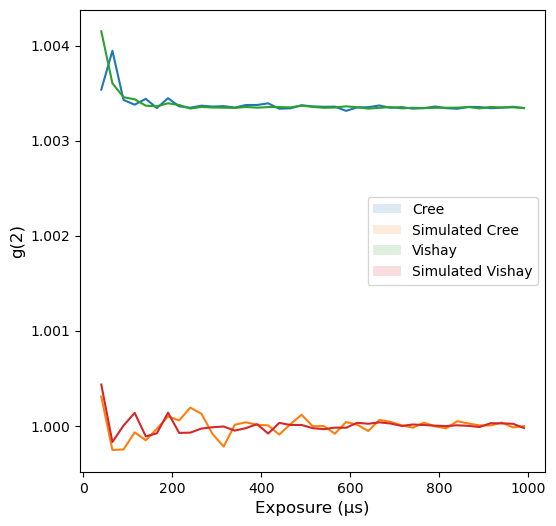

In [47]:
# CP41B LED
LED = "CP41B LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/CP41B/Spatial_SOCF_"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "Spatial_SOCF_correlations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Cree")
print(var)
# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    SOCF_array = []
    for q in range(0,100, 1):
        if q == 1830:
            SOCF_array.append(SOCF(Ref_pixel, Ref_pixel))
        else:
            SOCF_array.append(SOCF(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(SOCF_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Cree")

# TLHG LED
LED = "TLHG LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/TLHG/Spatial_SOCF_"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "Spatial_SOCF_correlations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Vishay")
# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/TLHG/ROI60x60/exp"
File_final = "gain20.000000Voltage1.910000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    SOCF_array = []
    for q in range(0,100, 1):
        if q == 1830:
            SOCF_array.append(SOCF(Ref_pixel, Ref_pixel))
        else:
            SOCF_array.append(SOCF(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(SOCF_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)

plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Vishay", leg_loc ="center right", y_label = "g(2)", figname = "SOCF evolution" )

1.003341788888889 4.129907765432124e-08


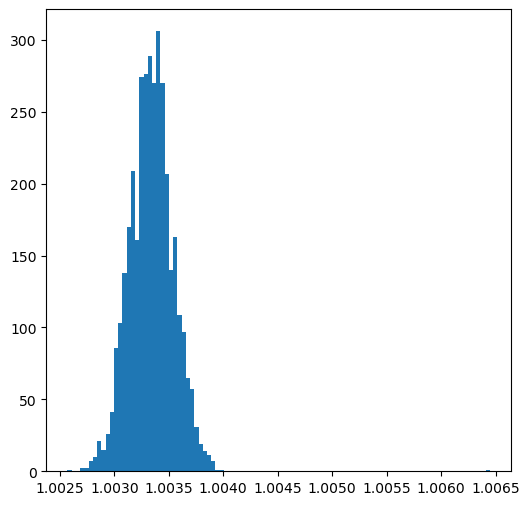

In [166]:
# CP41B LED
LED = "CP41B LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/CP41B/Spatial_SOCF_"
mean = []
var = []
Exposure = []
for i in range(990,1000,1000):
    rows, xxx = Loading_CSV(Path + str(i) + "Spatial_SOCF_correlations1830.csv")
plt.hist(reduce(add,rows), bins = 100)
print(np.average(reduce(add,rows)), np.var(reduce(add,rows)) )

## Cross-Correlation

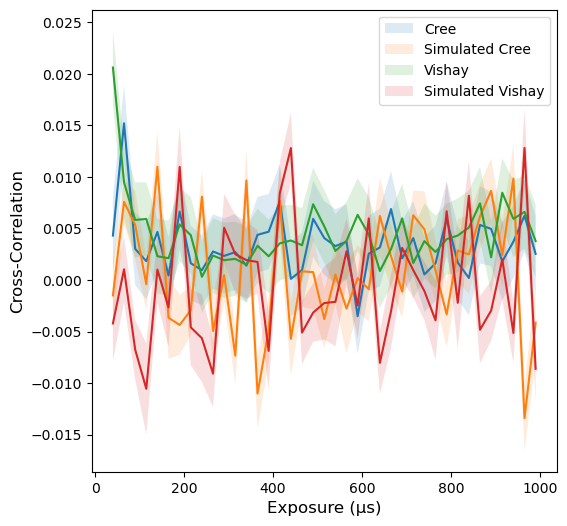

In [48]:
# CP41B LED
LED = "CP41B LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/CP41B/ACF"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "ACFcorrelations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Cree")

# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    IAC_array = []
    for q in range(0,100, 1):
        if q == 1830:
            IAC_array.append(Inter_Auto_Corr(Ref_pixel, Ref_pixel))
        else:
            IAC_array.append(Inter_Auto_Corr(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(IAC_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Cree")

# TLHG LED
LED = "TLHG LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/TLHG/ACF"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "ACFcorrelations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Vishay")

Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/TLHG/ROI60x60/exp"
File_final = "gain20.000000Voltage1.910000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    IAC_array = []
    for q in range(0,100, 1):
        if q == 1830:
            IAC_array.append(Inter_Auto_Corr(Ref_pixel, Ref_pixel))
        else:
            IAC_array.append(Inter_Auto_Corr(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(IAC_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Vishay",  y_label = "Cross-Correlation", figname = "CCF evolution" )

## Mutual Information

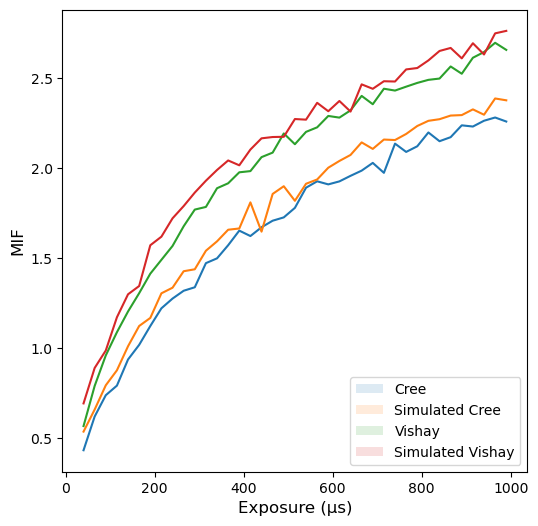

In [49]:
# CP41B LED
LED = "CP41B LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/CP41B/MIF"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "MIFcorrelations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Cree")

# Theory
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    IAC_array = []
    for q in range(0,10, 1):
        if q == 1830:
            IAC_array.append(calc_mutual_information(Ref_pixel, Ref_pixel))
        else:
            IAC_array.append(calc_mutual_information(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(IAC_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Cree")

# TLHG LED
LED = "TLHG LED"
fig_type = "SSOCF"
Path = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/Raw_Corr/TLHG/MIF"
mean = []
var = []
Exposure = []
for i in range(40,1000,25):
    rows, xxx = Loading_CSV(Path + str(i) + "MIFcorrelations1830.csv")
    m,v = corr_stats(reduce(add ,rows))
    mean.append(m)
    var.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean, var, label = "Vishay")

Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/TLHG/ROI60x60/exp"
File_final = "gain20.000000Voltage1.910000/IITM_QRNG87.txt"
Exposure = []
mean_theory = []
var_theory = [] 
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename)
    Ref_pixel = Poisson_list(np.average(data), 300)
    IAC_array = []
    for q in range(0,10, 1):
        if q == 1830:
            IAC_array.append(calc_mutual_information(Ref_pixel, Ref_pixel))
        else:
            IAC_array.append(calc_mutual_information(Ref_pixel, Poisson_list(np.average(data), 300)))
    m,v = corr_stats(IAC_array)
    mean_theory.append(m)
    var_theory.append(v)
    Exposure.append(i)
plot_w_error_band(Exposure ,mean_theory, var_theory, label = "Simulated Vishay", leg_loc ="lower right",  y_label = "MIF", figname = "MIF evolution" )

## Minimum Entropy

[40, 65, 90, 115, 140, 165, 190, 215, 240, 265, 290, 315, 340, 365, 390, 415, 440, 465, 490, 515, 540, 565, 590, 615, 640, 665, 690, 715, 740, 765, 790, 815, 840, 865, 890, 915, 940, 965, 990]


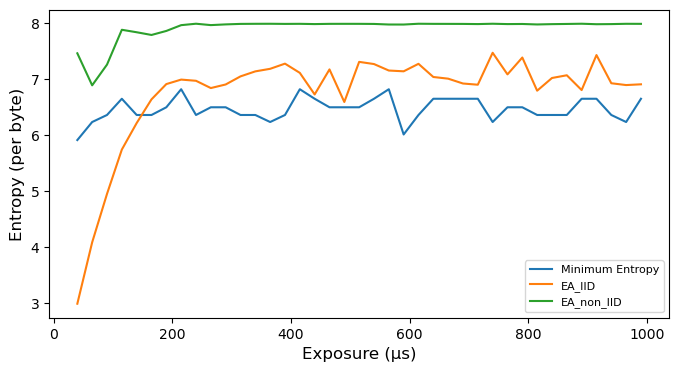

In [60]:
Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/TLHG/ROI60x60/exp"
File_final = "gain20.000000Voltage1.910000/IITM_QRNG87.txt"
x = []
y = []
y_ext = []
for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename, formatted = False)
    y.append(Min_entropy(data))
    data = Data_loading(filename, formatted = True)
    y_ext.append(Min_entropy(data))
    x.append(i)
#plt.plot(x,y, label = "Vishay LED")
#plt.plot(x, y_ext, label = "Vishay Extracted")

Folder = "C:/Users/albar/Desktop/IITM_QRNG/iitm_qrng_repos/QRNG_Correlation_Analysis/QRNG_Data/Experiment_8/CP41B/ROI60x60/exp"
File_final = "gain20.000000Voltage1.720000/IITM_QRNG87.txt"
x = []
y = []
y_ext = []
plt.figure(figsize=(8,4),dpi = 100)

for i in range(40,1000,25):
    filename = Folder+str(i)+File_final
    data = Data_loading(filename, formatted = False)
    y.append(Min_entropy(data))
    data = Data_loading(filename, formatted = True)
    y_ext.append(Min_entropy(data))
    x.append(i)

#plt.plot(x,y, label = "Cree LED")
plt.plot(x, y_ext, label = "Minimum Entropy")

ea_iid = [0.373291,0.510217, 0.618204, 0.717081, 0.776288, 0.829163, 0.863214, 0.873240, 0.870570, 0.854350, 0.862331, 0.880391, 0.891565, 0.897287, 0.908822, 0.888231,
          0.840104, 0.895947, 0.823289, 0.912770, 0.907908, 0.893452, 0.891710, 0.908409, 0.879043, 0.875308, 0.864500, 0.861811, 0.933069, 0.884867, 0.922455, 0.848460,
          0.876802, 0.882877, 0.849875, 0.927926, 0.865081, 0.861034, 0.862713]
ea_non_iid = [0.931872, 0.860445,0.906656, 0.984344, 0.978838, 0.972783, 0.981769, 0.994668, 0.997861, 0.994775, 0.996358, 0.997462, 0.997676, 0.997763, 0.997451, 0.997640,
              0.997054, 0.997575, 0.997629, 0.997605, 0.997377, 0.996103, 0.996040, 0.997819, 0.997560, 0.997508, 0.997430, 0.997073, 0.997830, 0.997052, 0.997278, 0.996230,
              0.996928, 0.997350, 0.997845, 0.996762, 0.997025, 0.997690, 0.997583]

exposure = []
for i in range(40,1000,25):
    exposure.append(i)
for i in range(0,len(ea_iid), 1):
    ea_iid[i] = ea_iid[i]*8
    ea_non_iid[i] = ea_non_iid[i]*8

print(exposure)
plt.plot(exposure, ea_iid, label = "EA_IID")
plt.plot(exposure, ea_non_iid, label = "EA_non_IID")


plt.xlabel("Exposure (\u03BCs)", fontsize=12)
plt.ylabel("Entropy (per byte)", fontsize=12)

plt.legend(loc= 'lower right', fontsize=8)
plt.savefig("entropy.png",bbox_inches='tight')

[40, 65, 90, 115, 140, 165, 190, 215, 240, 265, 290, 315, 340, 365, 390, 415, 440, 465, 490, 515, 540, 565, 590, 615, 640, 665, 690, 715, 740, 765, 790, 815, 840, 865, 890, 915, 940, 965, 990]


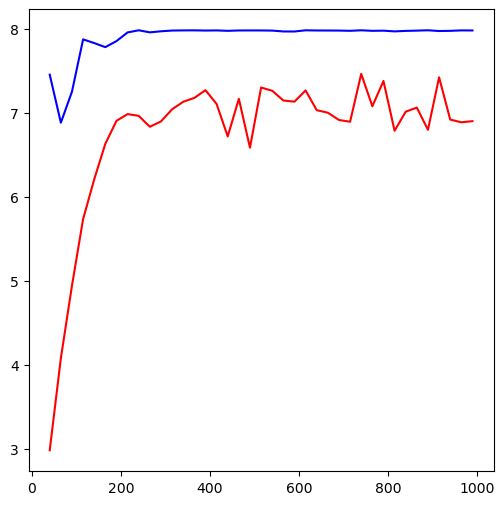

In [19]:
ea_iid = [0.373291,0.510217, 0.618204, 0.717081, 0.776288, 0.829163, 0.863214, 0.873240, 0.870570, 0.854350, 0.862331, 0.880391, 0.891565, 0.897287, 0.908822, 0.888231,
          0.840104, 0.895947, 0.823289, 0.912770, 0.907908, 0.893452, 0.891710, 0.908409, 0.879043, 0.875308, 0.864500, 0.861811, 0.933069, 0.884867, 0.922455, 0.848460,
          0.876802, 0.882877, 0.849875, 0.927926, 0.865081, 0.861034, 0.862713]
ea_non_iid = [0.931872, 0.860445,0.906656, 0.984344, 0.978838, 0.972783, 0.981769, 0.994668, 0.997861, 0.994775, 0.996358, 0.997462, 0.997676, 0.997763, 0.997451, 0.997640,
              0.997054, 0.997575, 0.997629, 0.997605, 0.997377, 0.996103, 0.996040, 0.997819, 0.997560, 0.997508, 0.997430, 0.997073, 0.997830, 0.997052, 0.997278, 0.996230,
              0.996928, 0.997350, 0.997845, 0.996762, 0.997025, 0.997690, 0.997583]

exposure = []
for i in range(40,1000,25):
    exposure.append(i)
for i in range(0,len(ea_iid), 1):
    ea_iid[i] = ea_iid[i]*8
    ea_non_iid[i] = ea_non_iid[i]*8

print(exposure)
plt.plot(exposure, ea_iid, color = "red")
plt.plot(exposure, ea_non_iid, color = "blue")